In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import dill
import pandas as pd
from scipy import optimize as opt
from sklearn.preprocessing import MinMaxScaler
import time
import sys
sys.path.append('../../')
import src

np.random.seed(383461)

min_periods = 3 #Min window period for standard deviation
#Parameter limits that make sense for the product (Hand-picked this time)
optimization_limits = [(-4, 0.05), (-5, 4), (1.35, 0.2), (-1, 1)]


#Load policy and value function
#####################
#file_n = "2019-4-12medium_prod_vfi_dict.dill"
file_n = "2019-4-27medium_prod_vfi_dict.dill"
with open('../../data/' + file_n, 'rb') as file:
    data_d = dill.load(file)

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']
lambdas_ext = src.generate_simplex_3dims(n_per_dim=
                                         data_d['n_of_lambdas_per_dim'])

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)


#dataframe and standard deviation
cleaned_data = "../../../firm_learning/data/cleaned_data/"

df = pd.read_csv(cleaned_data + "medium_prod_for_gmm.csv")
std_devs = (df.groupby('firm').level_prices.rolling(window=4, min=3)
            .std().reset_index()
            .rename(columns={'level_1': 't', 'level_prices': 'std_dev_prices'}))

df = pd.merge(df, std_devs, on=['firm', 't'], how='left')
df["dmd_shocks"] = np.random.normal(loc=0, scale=src.const.σ_ɛ, size=len(df))

mean_std_observed_prices = df.groupby('t').rolling_std_upc.mean()[min_periods:]

#Mix Max scaling for xs
xs = np.log(df.groupby('firm').xs.first().values + 0.1)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

Nfirms = len(xs)
# Just add zeroes. Makes sense for the gmm estimation
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=0)

Text(0.5, 1.0, 'Eβ')

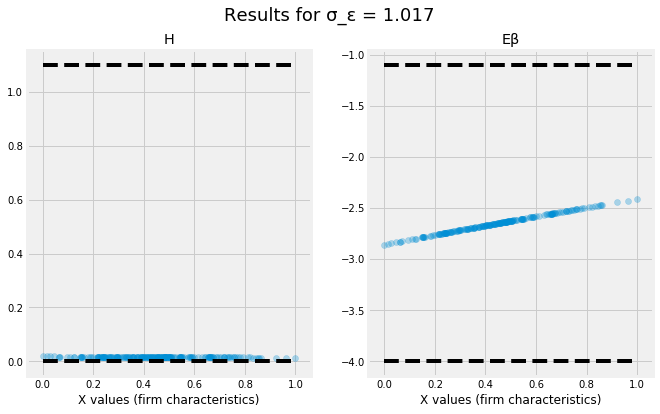

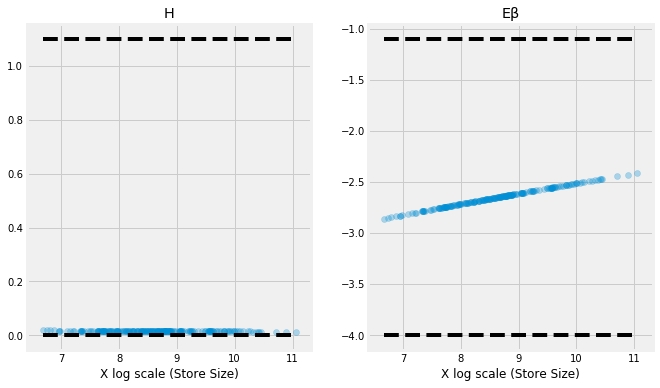

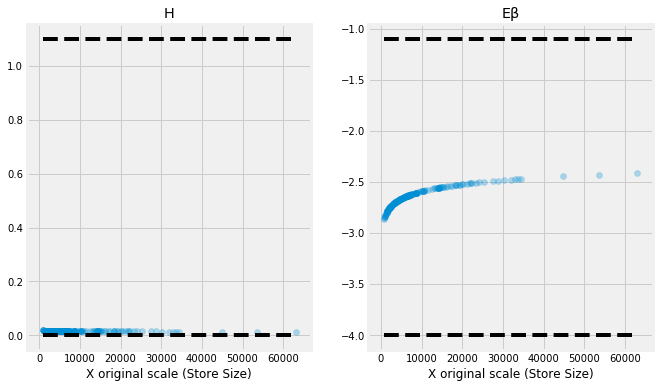

In [3]:

 
#Obtained results
#Old: θ = np.array([-0.53, -0.26,  0.52, -0.34])
θ = np.array([-3.98, -0.29,  1.05, -0.17])
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X values (firm characteristics)")
ax2.set_xlabel("X values (firm characteristics)")

ax1.scatter(xs, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., xs.min(), xs.max(), linestyles="dashed")
ax1.hlines(max_H_value, xs.min(), xs.max(), linestyles="dashed")
ax2.scatter(xs, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), xs.min(), xs.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), xs.min(), xs.max(), linestyles="dashed")
ax2.set_title("Eβ")
fig.suptitle("Results for σ_ɛ = 1.017", size=18)

#Plot over log Xs
orig_x = np.log(df.groupby('firm').xs.first().values) #log this?
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X log scale (Store Size)")
ax2.set_xlabel("X log scale (Store Size)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., orig_x.min(), orig_x.max(), linestyles="dashed")
ax1.hlines(max_H_value, orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.set_title("Eβ")

#Plot over original Xs
orig_x = (df.groupby('firm').xs.first().values) #log this?
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("X original scale (Store Size)")
ax2.set_xlabel("X original scale (Store Size)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("H")
max_H_value = np.log(3)
ax1.hlines(0., orig_x.min(), orig_x.max(), linestyles="dashed")
ax1.hlines(max_H_value, orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.hlines(src.betas_transition.min(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.hlines(src.betas_transition.max(), orig_x.min(), orig_x.max(), linestyles="dashed")
ax2.set_title("Eβ")


Text(0.5, 1.0, 'E[dmd elasticity] at launch')

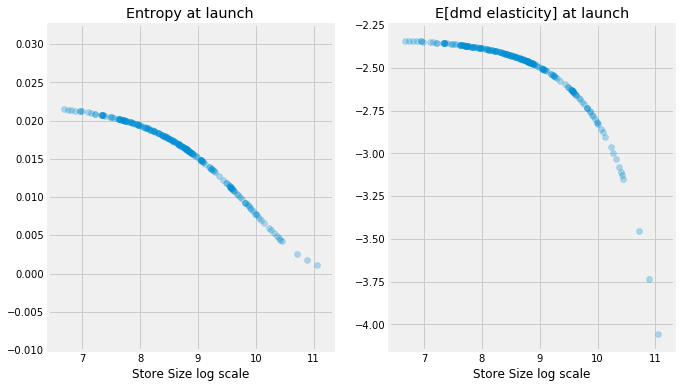

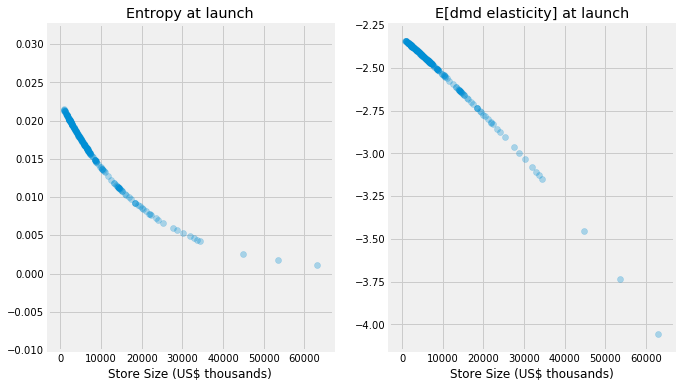

In [60]:
θ = [-3.84, -2.98,  0.85,  0.55] #delta 0.99. Convergió
#θ = np.array([-3.98, -0.29,  1.05, -0.17])  #esta está ok
H = np.e**((θ[0] + θ[1]*xs + prior_shocks))
Eβ = -np.e**(θ[2] + θ[3]*xs + prior_shocks)

#Plot over log Xs
orig_x = np.log(df.groupby('firm').xs.first().values) 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("Store Size log scale")
ax2.set_xlabel("Store Size log scale")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("Entropy at launch")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.set_title("E[dmd elasticity] at launch")

#Plot over original Xs
orig_x = (df.groupby('firm').xs.first().values) 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 6), sharex=True)
ax1.set_xlabel("Store Size (US$ thousands)")
ax2.set_xlabel("Store Size (US$ thousands)")

ax1.scatter(orig_x, H, alpha=0.3)
ax1.set_title("Entropy at launch")
ax2.scatter(orig_x, Eβ, alpha=0.3)
ax2.set_title("E[dmd elasticity] at launch")

## Plot gmm as a function of parameters

Done with plot 0
Done with plot 1
Done with plot 2
Done with plot 3


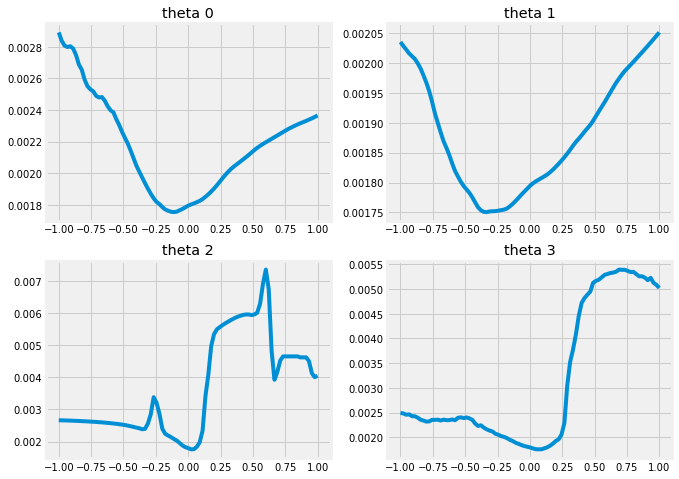

In [6]:
prior_shocks = src.gen_prior_shocks(Nfirms, σerror=0)


# Optimization
######################
def error_w_data(θ) -> float:
    return src.gmm_error(θ, policyF, xs,
                         mean_std_observed_prices=mean_std_observed_prices, df=df,
                         prior_shocks=prior_shocks, min_periods=min_periods)


def error_w_data_vector(θ_vector) -> float:
    error_vector = np.empty(len(θ_vector))
    for i, theta in enumerate(θ_vector):
        error_vector[i] = error_w_data(theta)
    return error_vector

optθ = np.array([-3.98, -0.29,  1.05, -0.17])

#Move each parameter by 30%
def domain_move_param(x, n_reps, perc=0.3):
    #return np.linspace(-perc*x, +perc*x, n_reps)
    return np.linspace(-1., 1., n_reps)

def move_one_parameter(optθ, n_reps, ind_to_change):
    repeated_res = np.repeat([optθ], n_reps, axis=0)
    movements = domain_move_param(optθ[ind_to_change], n_reps)
    for i in range(n_reps):
        repeated_res[i, ind_to_change] += movements[i]
    return repeated_res

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax0, ax1, ax2, ax3 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
n_reps = 91

for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(domain_move_param(optθ[i], n_reps), 
             error_w_data_vector(move_one_parameter(optθ, n_reps, i)))
    ax.set_title(f"theta {i}")
    print(f"Done with plot {i}")

#error_w_data(θ)

## Plot real vs expected moments

Text(0.5, 0, 'Weeks from launch')

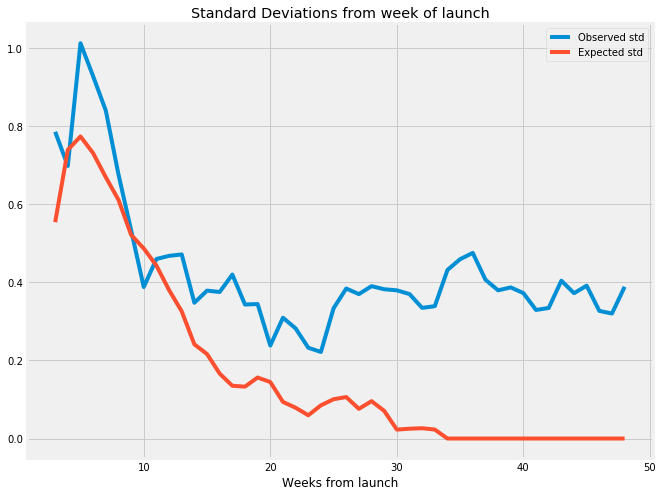

In [56]:
#optθ = [-0.53, -0.29,  0.62,  0.45]
optθ = np.array([-3.98, -0.29,  1.05, -0.17])
lambdas0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

mean_std_observed_prices_clean, mean_std_expected_prices = src.get_intersection_of_observed_and_expected_prices(
             mean_std_observed_prices, df, policyF, lambdas0, 3)



fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ind_t = mean_std_expected_prices.index
ax1.plot(ind_t, mean_std_observed_prices_clean, label="Observed std")
ax1.plot(ind_t, mean_std_expected_prices, label="Expected std")
ax1.legend()
ax1.set_title("Standard Deviations from week of launch")
ax1.set_xlabel("Weeks from launch")
#ax2.plot(mean_std_observed_prices.index, mean_std_observed_prices, label="Original observed std")
#ax2.legend()

## Plot Real vs Expected prices

In [ ]:


expected_prices = src.generate_pricing_decisions(policyF, lambda0, demand_obs,
                               dmd_shocks, use_real_dmd=False)


In [9]:
xs = (df.groupby('firm').xs.first().values + 0.1)
scaler = MinMaxScaler()
xs = scaler.fit_transform(xs.reshape(-1, 1)).flatten()

optθ = np.array([-3.98, -0.29,  1.05, -0.17])
lambdas_at_0 = src.from_theta_to_lambda_for_all_firms(optθ, xs, prior_shocks)

pricing_decision_dfs = []
for i, firm in enumerate(df.firm.unique()):
    prices = src.generate_pricing_decisions(policyF, lambdas_at_0[i],
                                            df[df.firm == firm].log_dmd.values,
                                            df[df.firm == firm].dmd_shocks.values)
    pricing_decision_dfs.append(pd.DataFrame({'level_prices': prices,
                                              'firm': np.repeat(firm, len(prices))
                                              }))

pricing_decision_df = pd.concat(pricing_decision_dfs, axis=0)

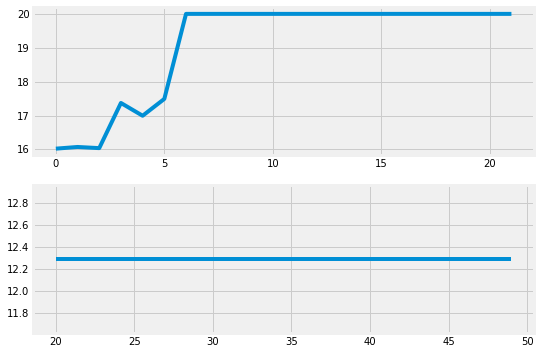

In [55]:
firms = df.firm.unique()
firm_i = firms[99]
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(pricing_decision_df[pricing_decision_df.firm==firm_i].index,
       pricing_decision_df[pricing_decision_df.firm==firm_i].level_prices)
ax2.plot(df[df.firm==firm_i].t, df[df.firm==firm_i].level_prices)

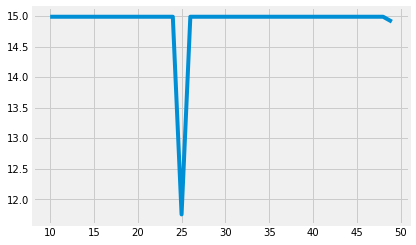

In [39]:
fig, ax = plt.subplots(1, 1)


In [32]:
df.firm.unique()

array([ 200171,  200197,  200439,  200494,  200542,  200578,  200610,
        200635,  204544,  206587,  211301,  214709,  216202,  218312,
        219777,  222124,  222577,  223199,  225023,  225677,  225757,
        226079,  227169,  230104,  231251,  231720,  232633,  233246,
        233555,  233779,  236100,  237107,  237670,  238732,  238854,
        238945,  239593,  239992,  240028,  240314,  240692,  240713,
        241516,  241565,  243432,  243939,  245593,  245748,  246366,
        246371,  247301,  247479,  247743,  249409,  249875,  250872,
        251254,  251550,  251986,  252570,  252805,  252869,  253077,
        253139,  253599,  254648,  255909,  256370,  256420,  257178,
        257658,  257871,  258162,  258282,  259543,  259693,  259905,
        260288,  261782,  262295,  262430,  262684,  262996,  263066,
        263478,  263584,  264605,  264945,  264965,  265080,  266131,
        266628,  266729,  267597,  267699,  269039,  269827,  270348,
        270612,  271

In [20]:
from scipy.stats import entropy
entropies = np.empty(len(lambdas_at_0))
for i in range(len(entropies)):
    entropies[i] = entropy(lambdas_at_0[i, :])

In [15]:
len(lambdas_at_0)

207